In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_json
from df_utils import form_pred_df, form_last_quarter_df
from data import load_cf1_df
from download import form_quandl_url, multi_ticker_download


sns.set()
config = load_json("config.json")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
my_tickers = ['EXP', 'WOR', 'CMC', 'MAS', 'NEM', 
'USM', 'TDS', 'LUMN',
'MSGS', 'WHR', 'BERY', 'DHI', 'F', 'WSM',
'THS', 'K', 'STRA', 'TWOU', 'CHD', 'CAG',
'CLR', 'ET', 'VVV', 'HP',
'JEF', 'CACC', 'PGR', 'FCFS', 'MKL',
'SRPT', 'MRK', 'BLUE', 'UHS', 'MCK',
'CAR', 'KNX', 'AYI', 'NOC', 'MMS', 'AVAV',
'NRZ', 'AGNC', 'KIM', 'CIM', 'OUT',
'HPE', 'CSOD', 'PINC', 'OSTK', 'FICO', 'SWI', 'WORK', 'ZNGA', 'JCOM', 'XRX',
'VST', 'CMS', 'ETR', 'SWX', 'INTC'
]

In [19]:
url = form_quandl_url('datatables/SHARADAR/SF1?ticker={ticker}', config)
multi_ticker_download(url, my_tickers, '{}/cf1/core_fundamental'.format(config['data_path']), skip_exists=True)

url = form_quandl_url('datatables/SHARADAR/DAILY?ticker={ticker}', config)
multi_ticker_download(url, my_tickers, '{}/cf1/daily'.format(config['data_path']), skip_exists=True)

100%|██████████| 1/1 [00:00<00:00, 1190.21it/s]


In [20]:
tickers_df = pd.read_csv('{}/cf1/tickers.csv'.format(config['data_path']))
tickers_df = tickers_df[tickers_df['currency']=='USD']
tickers_df = tickers_df[tickers_df['scalemarketcap'].apply(lambda x: x in ['4 - Mid', '5 - Large', '6 - Mega'])]

In [21]:
with open('models_data/marketcap_model.pickle', 'rb') as f:
    marketcap_model = pickle.load(f)

with open('models_data/feat_calculator.pickle', 'rb') as f:
    feat_calculator = pickle.load(f) 

In [22]:
X = feat_calculator.calc_feats(my_tickers)

100%|██████████| 60/60 [00:00<00:00, 229196.94it/s]


In [23]:
pred = marketcap_model.predict(X.drop(['ticker', 'marketcap', 'date'], axis=1), X['ticker'])
pred = np.exp(pred)

In [24]:
pred_df = form_pred_df(X, pred, tickers_df)
last_quarter_df = form_last_quarter_df(pred_df)

100%|██████████| 60/60 [00:00<00:00, 415.06it/s]


In [25]:
last_quarter_df

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
0,SRPT,2020-11-05,1.145423e+10,1.842883e+10,Healthcare,NASDAQ,Pharmaceutical Preparations,1.608910,7.752400e+09,2.377177,1.101276,2.158566
1,MRK,2020-11-05,2.035666e+11,2.934453e+11,Healthcare,NYSE,Pharmaceutical Preparations,1.441520,2.048822e+11,1.432264,0.775357,1.847231
2,BLUE,2020-11-04,3.886158e+09,7.670717e+09,Healthcare,NASDAQ,Biological Products (No Disgnostic Substances),1.973856,3.095700e+09,2.477862,1.382347,1.792503
3,NEM,2020-10-29,4.711695e+10,4.357484e+10,Basic Materials,NYSE,Gold And Silver Ores,0.924823,4.960740e+10,0.878394,0.550711,1.595018
4,USM,2020-11-05,2.586227e+09,5.893700e+09,Communication Services,NYSE,Radiotelephone Communications,2.278879,2.910600e+09,2.024909,1.274799,1.588414
5,MSGS,2020-11-09,3.653618e+09,4.068325e+09,Consumer Cyclical,NYSE,Services-Miscellaneous Amusement & Recreation,1.113506,4.203600e+09,0.967819,0.622621,1.554427
6,MKL,2020-10-27,1.335992e+10,1.588117e+10,Financial Services,NYSE,Fire Marine & Casualty Insurance,1.188717,1.369270e+10,1.159827,0.752936,1.540406
7,HPE,2020-12-10,1.567722e+10,4.760197e+10,Technology,NYSE,Wholesale-Computers & Peripheral Equipment & S...,3.036379,1.570310e+10,3.031374,2.101224,1.442670
8,CACC,2020-10-29,5.626975e+09,7.952101e+09,Financial Services,NASDAQ,Personal Credit Institutions,1.413211,5.739400e+09,1.385528,0.988324,1.401896
9,UHS,2020-11-06,9.910546e+09,2.086376e+10,Healthcare,NYSE,Services-General Medical & Surgical Hospitals Nec,2.105208,1.097110e+10,1.901702,1.372774,1.385298


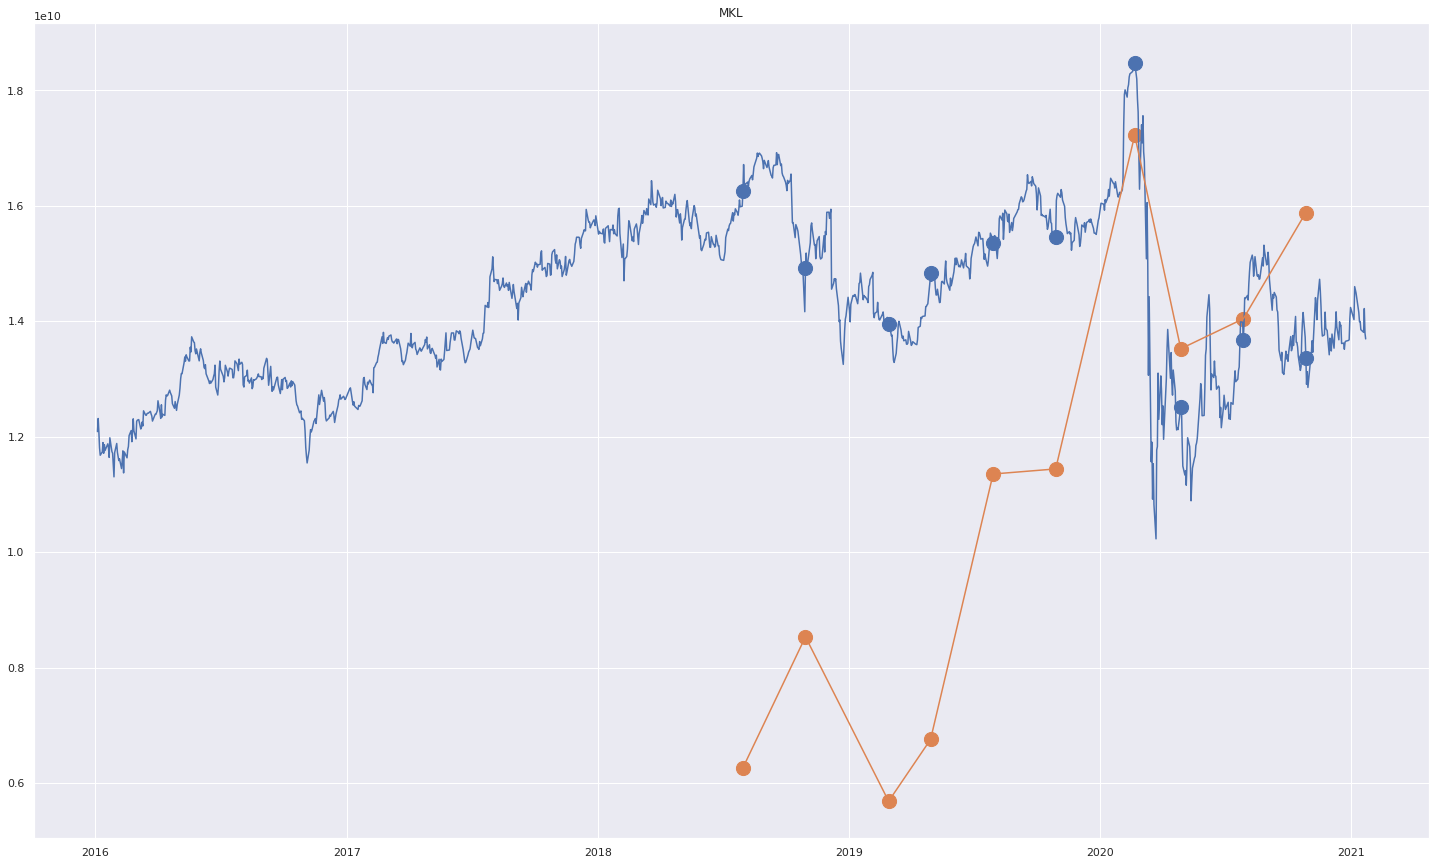

In [27]:
ticker = 'MKL'

daily_df = load_cf1_df('{}/cf1/daily/{}.json'.format(config['data_path'], ticker))
X_curr = X[X['ticker']==ticker]
pred_curr = pred_df[pred_df['ticker']==ticker]


plt.figure(figsize=(25,15))
plt.title(ticker)
plt.plot([np.datetime64(x) for x in daily_df['date']][::-1], daily_df['marketcap'].values[::-1] * 1e6)
plt.scatter([np.datetime64(x) for x in X_curr['date']][::-1], X_curr['marketcap'].values[::-1], s=200)
plt.scatter([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1], s=200)
plt.plot([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1])
plt.show()

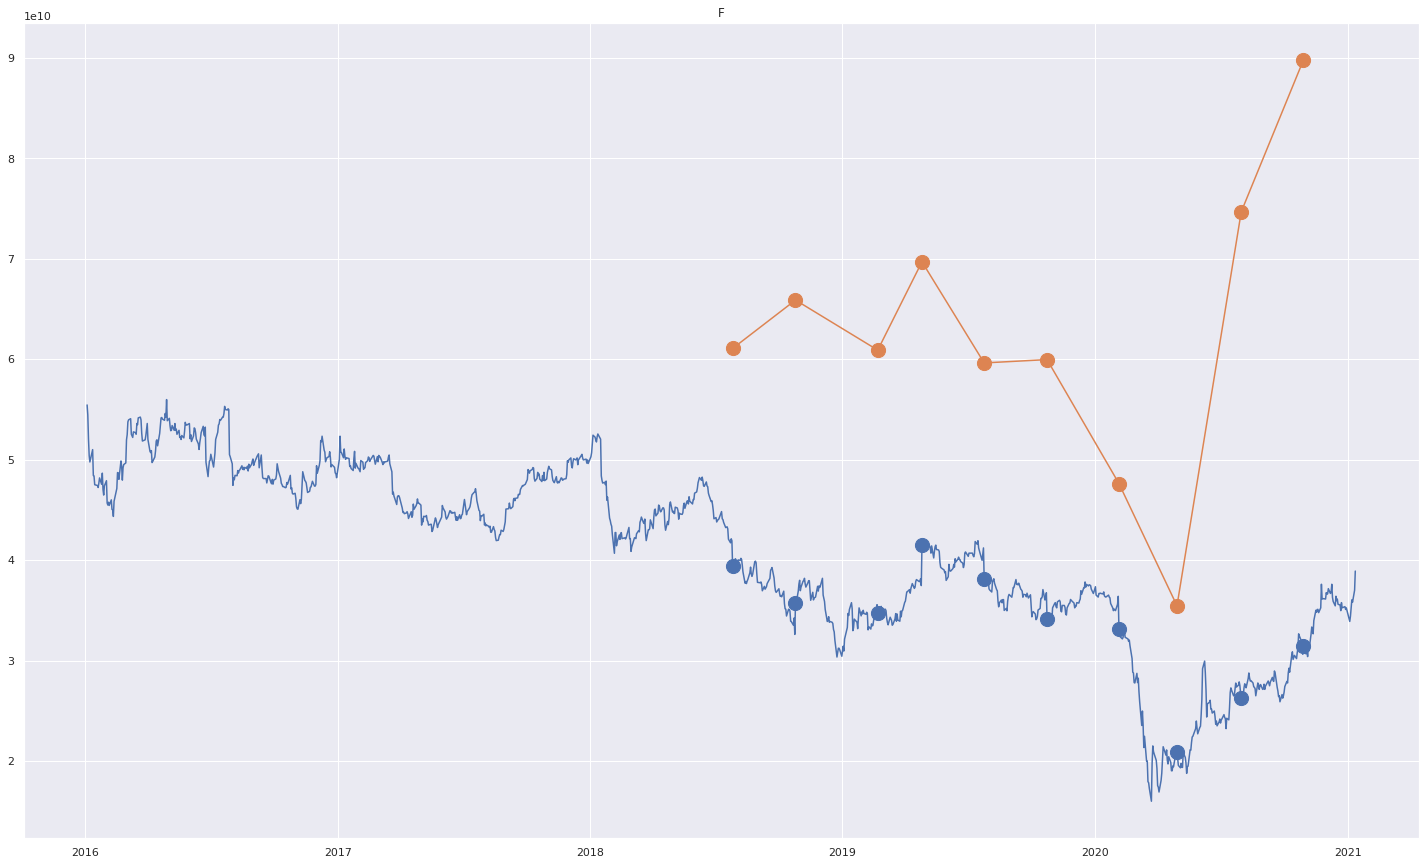

In [35]:
ticker = 'F'

daily_df = load_cf1_df('{}/cf1/daily/{}.json'.format(config['data_path'], ticker))
X_curr = X[X['ticker']==ticker]
pred_curr = pred_df[pred_df['ticker']==ticker]


plt.figure(figsize=(25,15))
plt.title(ticker)
plt.plot([np.datetime64(x) for x in daily_df['date']][::-1], daily_df['marketcap'].values[::-1] * 1e6)
plt.scatter([np.datetime64(x) for x in X_curr['date']][::-1], X_curr['marketcap'].values[::-1], s=200)
plt.scatter([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1], s=200)
plt.plot([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1])
plt.show()